# Analysing Prediction
## Load Configurations & Libraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install -Uq sentence-transformers
# !pip install scikit-learn
# !pip install tabulate

In [3]:
apipath = r'/content/drive/MyDrive/config/hbqa-colab.txt'
# apipath = r'H:\\My Drive\\config\\hbqa.txt'
import configparser

config = configparser.ConfigParser()
config.read(apipath)

datapath = config['global']['DATA_FOLDER']
corpuspath = config['global']['CORPUS_FOLDER']
corpus_sectionpath = config['global']['CORPUS_FOLDER_SECTIONS']
# OPENAI_KEY = config['global']['OPENAI_KEY']
# PINECONE_KEY = config['global']['PINECONE_KEY']
# PINECONE_ENV = config['global']['PINECONE_ENV']
# CHATPDF_KEY = config['global']['CHATPDF_KEY']


In [4]:
import pandas as pd
pd.set_option('display.max_colwidth',20)

In [5]:
# import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
!pip install wordcloud
!pip install nltk


In [7]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Load the English stopwords
stop_words = set(stopwords.words('english'))

# Print the list of stopwords
len(stop_words)

# !pip install -U pip setuptools wheel
# !pip install -U --user spacy
# !python -m spacy download en_core_web_sm
# Some problem on github not able to download en_core_web_sm model.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


179

# Util functions for Analysis

In [9]:
def describe(df):
    summary = df.describe()
    sum_row = df.sum().to_frame().T
    sum_row.index = ['sum']
    summary = pd.concat([summary, sum_row])
    return summary

# Analysis: Corpus Dataset

In [31]:
df_corpus = pd.read_csv(datapath + '01.1-Mahabharat_Metadata.csv')
print(df_corpus.shape)
df_corpus.head(5)

(2100, 10)


,Book_Id,Book_Name,Section_Id,File_Name,URL,Section_Roman,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
0,1,Book 1: Adi Parva,Book01_002,mahabharata_01002.txt,https://www.mahabharataonline.com/translation/mahabharata_01002.php,Section I,7464,44206,45,5.92
1,2,Book 1: Adi Parva,Book01_003,mahabharata_01003.txt,https://www.mahabharataonline.com/translation/mahabharata_01003.php,Section II,8608,52123,33,6.06
2,3,Book 1: Adi Parva,Book01_004,mahabharata_01004.txt,https://www.mahabharataonline.com/translation/mahabharata_01004.php,Section III,6089,35041,48,5.75
3,4,Book 1: Adi Parva,Book01_005,mahabharata_01005.txt,https://www.mahabharataonline.com/translation/mahabharata_01005.php,Section IV,341,1991,4,5.84
4,5,Book 1: Adi Parva,Book01_006,mahabharata_01006.txt,https://www.mahabharataonline.com/translation/mahabharata_01006.php,Section V,876,5068,11,5.79


## Words Counts in Corpus

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace('"'," ").replace('\n',' ').replace('\r',' ')
    text = text.replace("'"," ").replace(")"," ").replace("("," ").replace("["," ").replace("]"," ").replace("&"," ").replace("`"," ")
    text = text.replace('.',' ').replace(',',' ').replace('?',' ').replace('!',' ').replace(':',' ').replace(';',' ')
    text = text.replace('--','-').replace('‘',' ').replace('’',' ').replace('—',' ')
    text =  text.replace('   ',' ').replace('  ',' ')
    return text

# Open the URL
mb_words = {}
for bookid in df_corpus.Book_Id:
    filename = corpus_sectionpath + df_corpus[df_corpus['Book_Id']==bookid]['File_Name'].iloc[0]
    # print(filename)
    with open(filename, "r") as file1:
        content = file1.readlines()
        content = "\n".join(content)
        content = clean_text(content)
        words = content.split(" ")
        for word in words:
            word = word.strip()
            if len(word)>2:
                if word[0]=="-":
                    word=word[1:]

            try:
                mb_words[word] = mb_words[word] +1
            except:
                mb_words[word] = 1

df_words = pd.DataFrame( list(mb_words.items()), columns=['Words','Count'])
df_words.to_csv(datapath + '31.5-Words-Statistics.csv', index=False)

In [ ]:
df_words.shape

In [ ]:
# df_words.to_markdown(datapath + '31.5-Words-Statistics.md', index=False)

In [11]:
df_words = pd.read_csv(datapath + '31.5-Words-Statistics.csv')
df_words.sort_values('Count',ascending=False, inplace=True)
df_words.shape

(30026, 2)

In [12]:
#remove stop words
df_words = df_words[~df_words.Words.isin(stop_words)]
df_words.to_markdown(datapath + '31.5-Words-Statistics.md', index=False)
df_words.shape

(29892, 2)

In [13]:
# keep_only = (df_words['Words'].str.len()>2) & (df_words['Count']<15000) & (df_words['Count']>20)
keep_only = (df_words['Words'].str.len()>2) & (df_words['Count']>200)
df_words = df_words[ keep_only]

In [14]:
df_words.head(20)

,Words,Count
114,thou,16029
1076,king,12781
38,one,12253
27,son,11374
142,said,10460
683,thy,9504
41,great,9354
124,thee,7774
342,like,7275
18,also,6615


In [ ]:
df_words.tail(20)

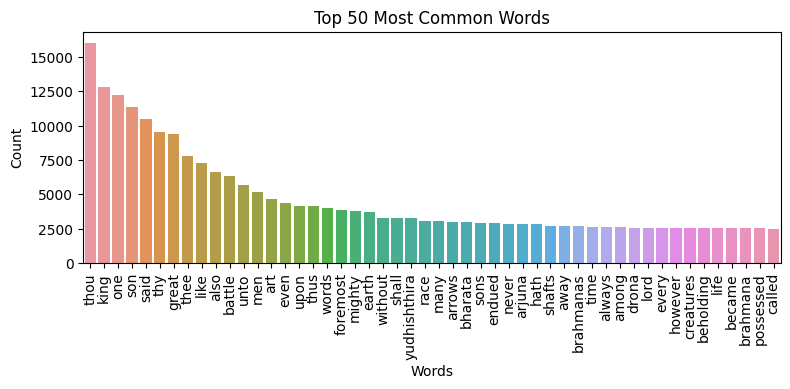

In [15]:
# Set the number of words you want to include in the plot (e.g., top 20)
num_words_to_plot = 50

# Select the top N words (most common) for the plot
top_words = df_words.head(num_words_to_plot)

# Create a barplot
plt.figure(figsize=(9, 3))
sns.barplot(x='Words', y='Count', data=top_words)
plt.title(f'Top {num_words_to_plot} Most Common Words')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# Show the plot
plt.show()

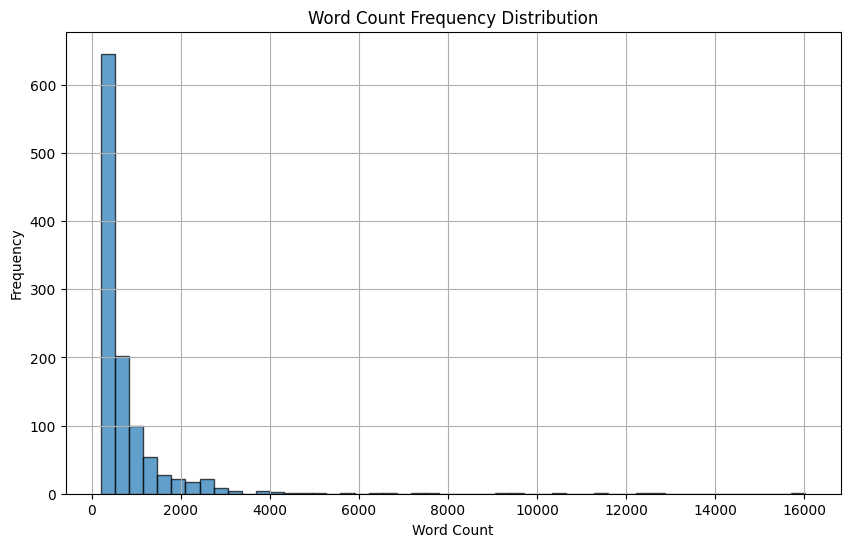

In [16]:
# Create a histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df_words['Count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Word Count Frequency Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# # Convert the word counts dictionary to a string
# text = " ".join([Words for row in df_words for _ in range(count)])

# # Create a WordCloud object
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# # Display the word cloud using Matplotlib
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")  # Hide the axis
# plt.show()


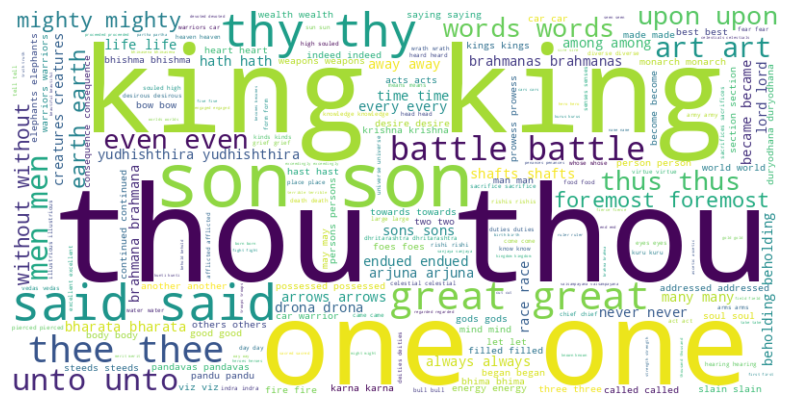

In [18]:
word_counts = df_words.set_index('Words')['Count'].to_dict()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert the word counts dictionary to a string
text = " ".join([word for word, count in word_counts.items() for _ in range(count)])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide the axis
plt.show()


## Analysis of Books

In [32]:
corpus_col = ['Book_Id', 'Book_Name', 'Section_Id', 'Section_Roman', 'Section_Word_Count', 'Section_Letter_Count',
       'Section_Para_Count', 'Avg_Word_Len']
corpus_col1 = ['Section_Id','Section_Word_Count', 'Section_Letter_Count','Section_Para_Count', 'Avg_Word_Len']
df_corpus = df_corpus[corpus_col]
df_corpus.head(3)

,Book_Id,Book_Name,Section_Id,Section_Roman,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
0,1,Book 1: Adi Parva,Book01_002,Section I,7464,44206,45,5.92
1,2,Book 1: Adi Parva,Book01_003,Section II,8608,52123,33,6.06
2,3,Book 1: Adi Parva,Book01_004,Section III,6089,35041,48,5.75


In [33]:
# Correct Book_Id Column
df_corpus['Book_Id'] = df_corpus['Section_Id'].str[:6]
df_corpus.head(3)

,Book_Id,Book_Name,Section_Id,Section_Roman,Section_Word_Count,Section_Letter_Count,Section_Para_Count,Avg_Word_Len
0,Book01,Book 1: Adi Parva,Book01_002,Section I,7464,44206,45,5.92
1,Book01,Book 1: Adi Parva,Book01_003,Section II,8608,52123,33,6.06
2,Book01,Book 1: Adi Parva,Book01_004,Section III,6089,35041,48,5.75


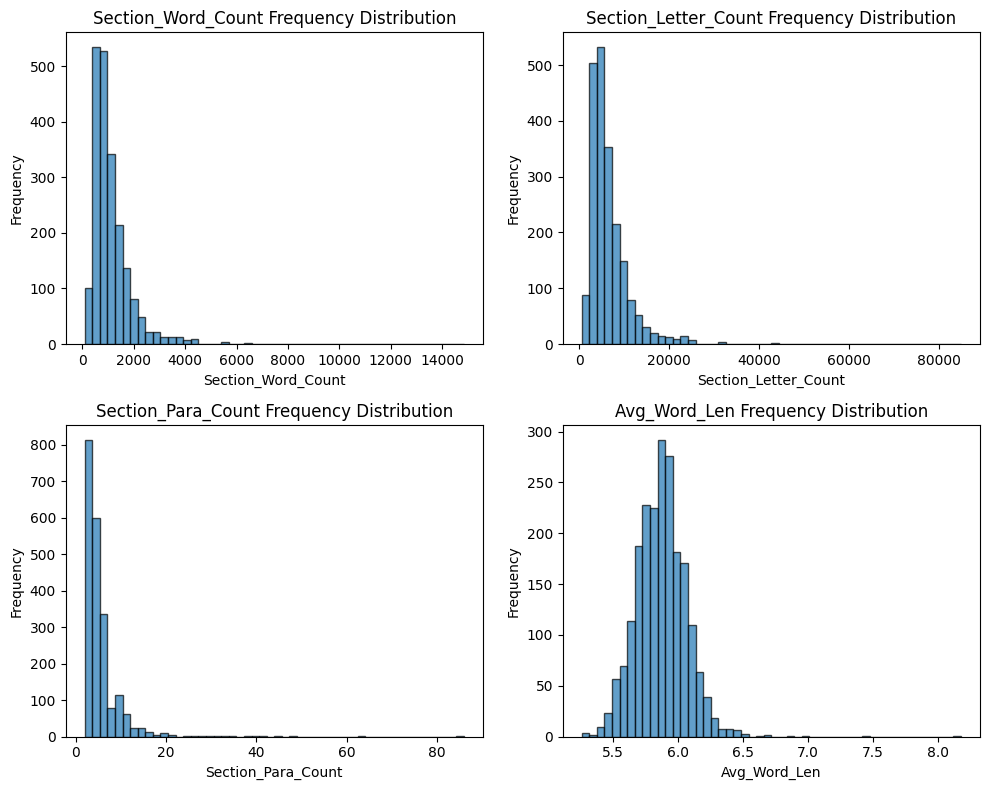

In [44]:
# Create a histogram of word counts
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(df_corpus['Section_Word_Count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Section_Word_Count Frequency Distribution')
plt.xlabel('Section_Word_Count')
plt.ylabel('Frequency')
plt.grid(False)

plt.subplot(2, 2, 2)
plt.hist(df_corpus['Section_Letter_Count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Section_Letter_Count Frequency Distribution')
plt.xlabel('Section_Letter_Count')
plt.ylabel('Frequency')
plt.grid(False)

plt.subplot(2, 2, 3)
plt.hist(df_corpus['Section_Para_Count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Section_Para_Count Frequency Distribution')
plt.xlabel('Section_Para_Count')
plt.ylabel('Frequency')
plt.grid(False)


plt.subplot(2, 2, 4)
plt.hist(df_corpus['Avg_Word_Len'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Avg_Word_Len Frequency Distribution')
plt.xlabel('Avg_Word_Len')
plt.ylabel('Frequency')
plt.grid(False)

# Show the plot

plt.tight_layout()
plt.show()

In [45]:
# Create Book_Id, Book_Name Dictionary

temp = df_corpus[['Book_Id','Book_Name']].drop_duplicates().reset_index()
book_names={}
for i in range(len(temp)):
    book_names[temp.loc[i,'Book_Id']] = temp.loc[i,'Book_Name']#.split(":")[1].strip()

book_names

{'Book01': 'Book 1: Adi Parva',
 'Book02': 'Book 2: Sabha Parva',
 'Book03': 'Book 3: Vana Parva',
 'Book04': 'Book 4: Virata Parva',
 'Book05': 'Book 5: Udyoga Parva',
 'Book06': 'Book 6: Bhishma Parva',
 'Book07': 'Book 7: Drona Parva',
 'Book08': 'Book 8: Karna Parva',
 'Book09': 'Book 9: Shalya Parva',
 'Book10': 'Book 10: Sauptika Parva',
 'Book11': 'Book 11: Stri Parva',
 'Book12': 'Book 12: Santi Parva',
 'Book13': 'Book 13: Anusasana Parva',
 'Book14': 'Book 14: Aswamedha Parva',
 'Book15': 'Book 15: Asramavasika Parva',
 'Book16': 'Book 16: Mausala Parva',
 'Book17': 'Book 17: Mahaprasthanika Parva',
 'Book18': 'Book 18: Svargarohanika Parva'}

In [46]:
# Get Parva wise Book Statistics based on Sum

agg_funcs = {
    'Section_Roman': 'count',               # Count the occurrences of Section_Roman
    'Section_Letter_Count': 'sum',        # Calculate the mean of Section_Letter_Count
    'Section_Word_Count': 'sum',          # Calculate the mean of Section_Word_Count
    'Section_Para_Count': 'sum',
    'Avg_Word_Len': 'mean'
}
df_corpus_book_sum = df_corpus.groupby('Book_Id').agg(agg_funcs).sort_index()
df_corpus_book_sum = df_corpus_book_sum.rename({
                        'Section_Roman': 'Number_of_Sections',
                        'Section_Letter_Count':'Letter_Count_In_Parva',
                        'Section_Word_Count': 'Word_Count_In_Parva',
                        'Section_Para_Count':'Para_Count_In_Parva',
                        'Avg_Word_Len': "Avg_Word_Len_In_Parva"}, axis=1)
df_corpus_book_sum

,Number_of_Sections,Letter_Count_In_Parva,Word_Count_In_Parva,Para_Count_In_Parva,Avg_Word_Len_In_Parva
Book_Id,,,,,
Book01,236,1331548,226993,1725,5.890424
Book02,79,436545,73308,421,5.950253
Book03,312,1858250,321351,1285,5.794423
Book04,72,351033,60134,338,5.840833
Book05,198,1091238,187212,719,5.836919
Book06,124,879533,147486,651,5.974516
Book07,198,1461621,245217,815,5.973182
Book08,96,814766,137646,331,5.936250
Book09,64,535508,90217,274,5.940000


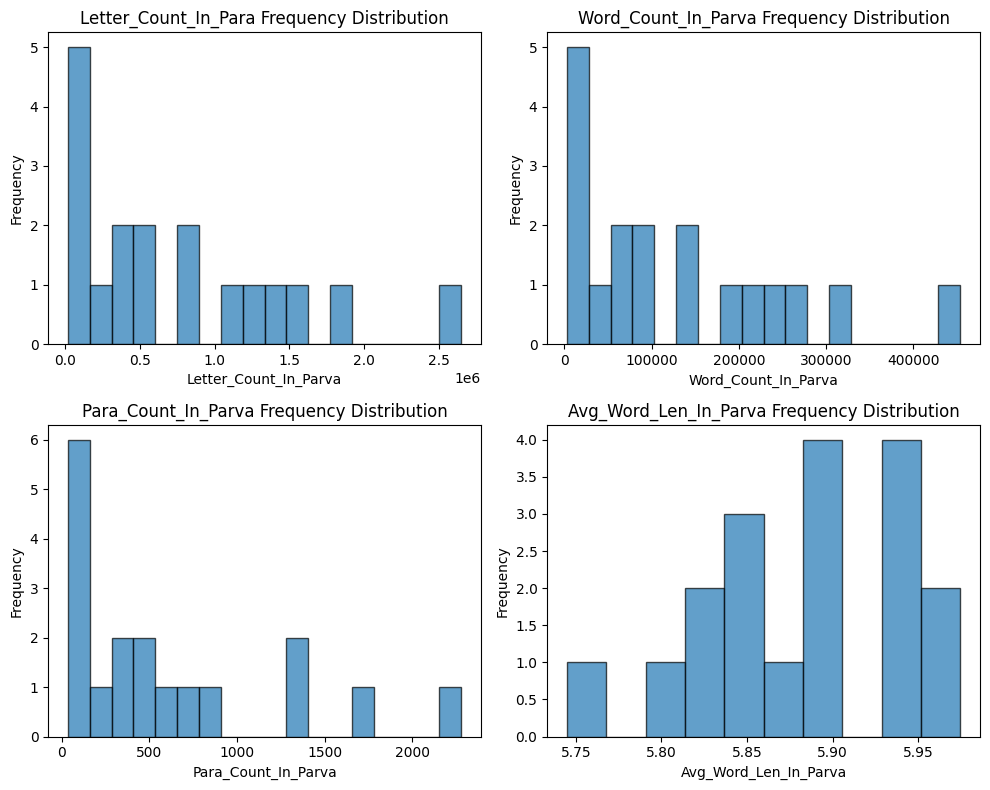

In [50]:
# Create a histogram of word counts
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.hist(df_corpus_book_sum['Letter_Count_In_Parva'], bins=18, edgecolor='k', alpha=0.7)
plt.title('Letter_Count_In_Para Frequency Distribution')
plt.xlabel('Letter_Count_In_Parva')
plt.ylabel('Frequency')
plt.grid(False)

plt.subplot(2, 2, 2)
plt.hist(df_corpus_book_sum['Word_Count_In_Parva'], bins=18, edgecolor='k', alpha=0.7)
plt.title('Word_Count_In_Parva Frequency Distribution')
plt.xlabel('Word_Count_In_Parva')
plt.ylabel('Frequency')
plt.grid(False)

plt.subplot(2, 2, 3)
plt.hist(df_corpus_book_sum['Para_Count_In_Parva'], bins=18, edgecolor='k', alpha=0.7)
plt.title('Para_Count_In_Parva Frequency Distribution')
plt.xlabel('Para_Count_In_Parva')
plt.ylabel('Frequency')
plt.grid(False)


plt.subplot(2, 2, 4)
plt.hist(df_corpus_book_sum['Avg_Word_Len_In_Parva'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Avg_Word_Len_In_Parva Frequency Distribution')
plt.xlabel('Avg_Word_Len_In_Parva')
plt.ylabel('Frequency')
plt.grid(False)

# Show the plot

plt.tight_layout()
plt.show()

In [23]:
# Get Parva wise Book Statistics based on Mean
agg_funcs = {
    'Section_Word_Count': 'mean',
    'Section_Letter_Count': 'mean',
    'Section_Para_Count': 'mean',

}
df_corpus_book_avg = df_corpus.groupby('Book_Id').agg(agg_funcs).sort_index()
df_corpus_book_avg = df_corpus_book_avg.rename({'Section_Word_Count':'Avg_Word_Count_Section',
                        'Section_Letter_Count': 'Avg_Letter_Count_Section',
                        'Section_Para_Count':'Avg_Para_Count_Section', }, axis=1)
df_corpus_book_avg

,Avg_Word_Count_Section,Avg_Letter_Count_Section,Avg_Para_Count_Section
Book_Id,,,
Book01,961.834746,5642.152542,7.309322
Book02,927.949367,5525.886076,5.329114
Book03,1029.971154,5955.929487,4.118590
Book04,835.194444,4875.458333,4.694444
Book05,945.515152,5511.303030,3.631313
Book06,1189.403226,7093.008065,5.250000
Book07,1238.469697,7381.924242,4.116162
Book08,1433.812500,8487.145833,3.447917
Book09,1409.640625,8367.312500,4.281250


In [24]:
#Combine datasets

df_corpus_book = df_corpus_book_sum.merge(df_corpus_book_avg,how="inner",on="Book_Id")
df_corpus_book

,Number_of_Sections,Letter_Count_In_Parva,Word_Count_In_Parva,Para_Count_In_Parva,Avg_Word_Len_In_Parva,Avg_Word_Count_Section,Avg_Letter_Count_Section,Avg_Para_Count_Section
Book_Id,,,,,,,,
Book01,236,1331548,226993,1725,5.890424,961.834746,5642.152542,7.309322
Book02,79,436545,73308,421,5.950253,927.949367,5525.886076,5.329114
Book03,312,1858250,321351,1285,5.794423,1029.971154,5955.929487,4.118590
Book04,72,351033,60134,338,5.840833,835.194444,4875.458333,4.694444
Book05,198,1091238,187212,719,5.836919,945.515152,5511.303030,3.631313
Book06,124,879533,147486,651,5.974516,1189.403226,7093.008065,5.250000
Book07,198,1461621,245217,815,5.973182,1238.469697,7381.924242,4.116162
Book08,96,814766,137646,331,5.936250,1433.812500,8487.145833,3.447917
Book09,64,535508,90217,274,5.940000,1409.640625,8367.312500,4.281250


In [25]:
# pd.options.display.float_format = '{:,.2f}'.format
describe(df_corpus_book)

,Number_of_Sections,Letter_Count_In_Parva,Word_Count_In_Parva,Para_Count_In_Parva,Avg_Word_Len_In_Parva,Avg_Word_Count_Section,Avg_Letter_Count_Section,Avg_Para_Count_Section
count,18.000000,1.800000e+01,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000
mean,116.666667,7.776994e+05,1.328089e+05,623.166667,5.883110,1102.856698,6481.292207,6.017055
std,107.720226,7.477799e+05,1.284734e+05,641.456546,0.064288,250.795253,1467.223895,2.922273
min,3.000000,1.684000e+04,2.866000e+03,35.000000,5.744790,775.461538,4567.743590,3.447917
25%,28.500000,1.370480e+05,2.334675e+04,155.250000,5.837898,932.340813,5514.948792,4.116769
50%,85.500000,5.060330e+05,8.538550e+04,379.500000,5.891879,995.902950,5799.041015,5.000000
75%,190.250000,1.271470e+06,2.170478e+05,791.000000,5.939063,1247.797176,7362.111226,7.051551
max,363.000000,2.650870e+06,4.540790e+05,2279.000000,5.974516,1647.143713,9430.592814,14.000000
sum,2100.000000,1.399859e+07,2.390561e+06,11217.000000,105.895979,19851.420565,116663.259728,108.306996


In [26]:
df_corpus_book.columns

Index(['Number_of_Sections', 'Letter_Count_In_Parva', 'Word_Count_In_Parva',
       'Para_Count_In_Parva', 'Avg_Word_Len_In_Parva',
       'Avg_Word_Count_Section', 'Avg_Letter_Count_Section',
       'Avg_Para_Count_Section'],
      dtype='object')

In [27]:
# This is required to create a heatmap

df_corpus_book_scaled = df_corpus_book.copy(deep=True)

minmax = MinMaxScaler()
import numpy as np
df_corpus_book_scaled['Number_of_Sections'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Number_of_Sections'])).reshape(-1,1) )
df_corpus_book_scaled['Letter_Count_In_Parva'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Letter_Count_In_Parva'])).reshape(-1,1) )
df_corpus_book_scaled['Word_Count_In_Parva'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Word_Count_In_Parva'])).reshape(-1,1) )
df_corpus_book_scaled['Para_Count_In_Parva'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Para_Count_In_Parva'])).reshape(-1,1) )
df_corpus_book_scaled['Avg_Word_Len_In_Parva'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Avg_Word_Len_In_Parva'])).reshape(-1,1) )

df_corpus_book_scaled['Avg_Word_Count_Section'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Avg_Word_Count_Section'])).reshape(-1,1) )
df_corpus_book_scaled['Avg_Letter_Count_Section'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Avg_Letter_Count_Section'])).reshape(-1,1) )
df_corpus_book_scaled['Avg_Para_Count_Section'] = minmax.fit_transform( np.array(list(df_corpus_book_scaled['Avg_Para_Count_Section'])).reshape(-1,1) )


df_corpus_book_scaled

,Number_of_Sections,Letter_Count_In_Parva,Word_Count_In_Parva,Para_Count_In_Parva,Avg_Word_Len_In_Parva,Avg_Word_Count_Section,Avg_Letter_Count_Section,Avg_Para_Count_Section
Book_Id,,,,,,,,
Book01,0.647222,0.499124,0.496721,0.753119,0.633944,0.213809,0.220942,0.365938
Book02,0.211111,0.159339,0.156117,0.172014,0.894383,0.174935,0.197033,0.178277
Book03,0.858333,0.699085,0.705842,0.557041,0.216052,0.291975,0.285468,0.063558
Book04,0.191667,0.126875,0.126920,0.135027,0.418076,0.068526,0.063279,0.118131
Book05,0.541667,0.407891,0.408556,0.304813,0.401038,0.195087,0.194034,0.017380
Book06,0.336111,0.327518,0.320514,0.274510,1.000000,0.474877,0.519297,0.170780
Book07,0.541667,0.548506,0.537110,0.347594,0.994192,0.531166,0.578710,0.063328
Book08,0.258333,0.302930,0.298706,0.131907,0.833427,0.755265,0.805989,0.000000
Book09,0.169444,0.196910,0.193591,0.106506,0.849751,0.727535,0.781346,0.078973


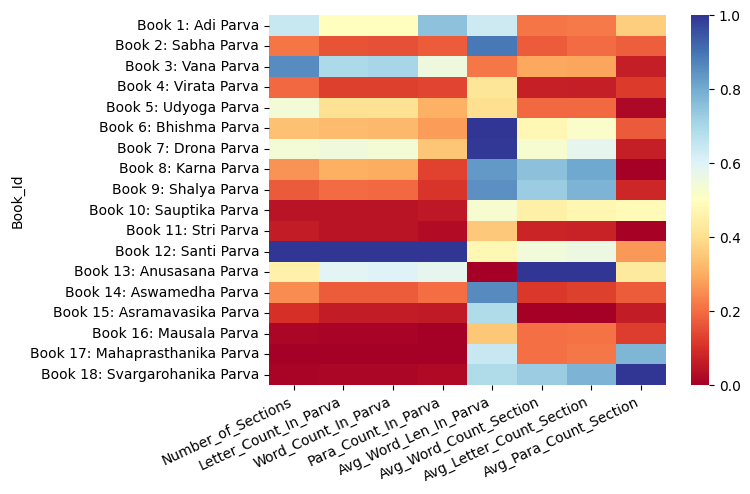

In [28]:
book_name= list(pd.DataFrame(list(book_names.items()), columns=['Book_Num', 'Book_Name'])['Book_Name'])
sns.heatmap(df_corpus_book_scaled,yticklabels=book_name,cmap='RdYlBu')
plt.xticks(rotation=25, ha="right")
plt.show()

In [29]:
df_corpus_book_scaled.corr()

,Number_of_Sections,Letter_Count_In_Parva,Word_Count_In_Parva,Para_Count_In_Parva,Avg_Word_Len_In_Parva,Avg_Word_Count_Section,Avg_Letter_Count_Section,Avg_Para_Count_Section
Number_of_Sections,1.000000,0.971033,0.970538,0.934462,-0.205230,0.162350,0.144361,-0.265130
Letter_Count_In_Parva,0.971033,1.000000,0.999859,0.940301,-0.216961,0.347669,0.328168,-0.218030
Word_Count_In_Parva,0.970538,0.999859,1.000000,0.941307,-0.231517,0.348915,0.328584,-0.213735
Para_Count_In_Parva,0.934462,0.940301,0.941307,1.000000,-0.256281,0.237399,0.214385,-0.077886
Avg_Word_Len_In_Parva,-0.205230,-0.216961,-0.231517,-0.256281,1.000000,-0.018742,0.035123,-0.046585
Avg_Word_Count_Section,0.162350,0.347669,0.348915,0.237399,-0.018742,1.000000,0.998324,0.291778
Avg_Letter_Count_Section,0.144361,0.328168,0.328584,0.214385,0.035123,0.998324,1.000000,0.291083
Avg_Para_Count_Section,-0.265130,-0.218030,-0.213735,-0.077886,-0.046585,0.291778,0.291083,1.000000


In [30]:
book_stats = {
              "Letters":"",
              "Minimum Number of Letters in any Parva": "16,840 (16.8 thousands)",
              'Average Number of Letters in any Parva': "777,699 (780 thousands)",
              "Maximum Number of Letters in any Parva": "2,650,870 (2.6 millions)",

              "Words":"",
              "Minimum Number of Words in any Parva": "2,866 (2.8 thousands)",
              "Average Number of Words in any Parva": "132,808 (133 thousands)",
              "Maximum Number of Words in any Parva": "454,079 (450 thousands)",

              "Paragraphs":"",
              "Minimum Number of Paragraphs in any Parva": "35",
              "Average Number of Paragraphs in any Parva": "623",
              "Maximum Number of Paragraphs in any Parva": "2,279 (2.2 thousands)",

              "Parva":"",
              "Total Number of Parva": "2100",
              "Total Number of Letters in All Parvas": "13,998,590 (13 millions)",
              "Total Number of Word in All Parvas":  "2,390,561 (2.4 millions)",
              "Total number of paragraph in All Parvas" : "11,217 (11.2 thousands)",
}

# save statistics in file
pd.set_option('display.max_colwidth',1000)
pd.DataFrame(list(book_stats.items()), columns=['Statistics of Mahabharat Book','Value']).to_markdown(datapath + '31.1-Book-Statistics.md', index=False)
pd.DataFrame(list(book_stats.items()), columns=['Statistics of Mahabharat Book','Value'])


,Statistics of Mahabharat Book,Value
0,Letters,
1,Minimum Number of Letters in any Parva,"16,840 (16.8 thousands)"
2,Average Number of Letters in any Parva,"777,699 (780 thousands)"
3,Maximum Number of Letters in any Parva,"2,650,870 (2.6 millions)"
4,Words,
5,Minimum Number of Words in any Parva,"2,866 (2.8 thousands)"
6,Average Number of Words in any Parva,"132,808 (133 thousands)"
7,Maximum Number of Words in any Parva,"454,079 (450 thousands)"
8,Paragraphs,
9,Minimum Number of Paragraphs in any Parva,35


In [ ]:
# Create a histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df_words['Count'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Word Count Frequency Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

## Section Level Summary of Book

In [ ]:
df_corpus[['Section_Word_Count', 'Section_Letter_Count', 'Section_Para_Count',
       'Avg_Word_Len']].describe()

In [ ]:
book_section_stats = {
              "Total Sections in Book": "2100",
              "Letters":"",
              "Minimum Number of Letters in any Section": "514",
              'Average Number of Letters': "6665 (6.5 K)",
              "Maximum Number of Letters in any Chapter" : "84950 (85 K)",
              "Words":"",
              "Minimum Number of Words in any Section": "90",
              "Average Number of Words": "1138",
              "Maximum Number of Words in any Chapter" : "14850 (15 K)",
              "Paragraphs":"",
              "Minimum Number of Paragraphs in any Section": "2",
              "Average Number of Paragraphs": "5.4",
              "Maximum Number of Paragraphs in any Chapters" : "86"
}


In [ ]:
# save statistics in file
pd.set_option('display.max_colwidth',200)
pd.DataFrame(list(book_section_stats.items()), columns=['Section Statistics of Mahabharat Book','Value']).to_markdown(datapath + '31.2-Book-Section-Statistics.md', index=False)
pd.DataFrame(list(book_section_stats.items()), columns=['Section Statistics of Mahabharat Book','Value'])


### Observations

There are 18 Parva in Mahabharat. In Enlgish they are referred as Book. In our work we call these Book.
Each Parva is subdivided into sub-parva. In English these sub-purvas are also referred as Chapter and some time as Section. In our work we call these Section.

Book 8, 9, 18 has highest number of words. These are bulky chapters. Book 4, 11, 15 has lese number of words.
Book 18 has highest number of paragraphs. Book 10, 13 has least number of paragraphs.
Average lenght of words in Book 6,7 is the highest. Book13, Book3 has smaller size words compare other Books.

Each section is different thread of story. Book 01, 03, 12 has highest number of stories.
Book 16, 17, 18 have least number of stories.

There is no relationship between "Average Word Length" and "Number of Words in Section", "Number of Paragraph in Section", "Number of Letters in Section".

18 Chapters in Mahabharat are as following.
'Book 1: Adi Parva',
'Book 2: Sabha Parva',
'Book 3: Vana Parva',
'Book 4: Virata Parva',
'Book 5: Udyoga Parva',
'Book 6: Bhishma Parva',
'Book 7: Drona Parva',
'Book 8: Karna Parva',
'Book 9: Shalya Parva',
'Book 10: Sauptika Parva',
'Book 11: Stri Parva',
'Book 12: Santi Parva',
'Book 13: Anusasana Parva',
'Book 14: Aswamedha Parva',
'Book 15: Asramavasika Parva',
'Book 16: Mausala Parva',
'Book 17: Mahaprasthanika Parva',
'Book 18: Svargarohanika Parva'

| Statistics of Mahabharat Book             | Value                    |
|:------------------------------------------|:-------------------------|
| Letters                                   |                          |
| Minimum Number of Letters in any Parva    | 16,840 (16.8 thousands)  |
| Average Number of Letters in any Parva    | 777,699 (780 thousands)  |
| Maximum Number of Letters in any Parva    | 2,650,870 (2.6 millions) |
| Words                                     |                          |
| Minimum Number of Words in any Parva      | 2,866 (2.8 thousands)    |
| Average Number of Words in any Parva      | 132,808 (133 thousands)  |
| Maximum Number of Words in any Parva      | 454,079 (450 thousands)  |
| Paragraphs                                |                          |
| Minimum Number of Paragraphs in any Parva | 35                       |
| Average Number of Paragraphs in any Parva | 623                      |
| Maximum Number of Paragraphs in any Parva | 2,279 (2.2 thousands)    |
| Parva                                     |                          |
| Total Number of Parva                     | 2100                     |
| Total Number of Letters in All Parvas     | 13,998,590 (13 millions) |
| Total Number of Word in All Parvas        | 2,390,561 (2.4 millions) |
| Total number of paragraph in All Parvas   | 11,217 (11.2 thousands)  |

## Book Section Statitics
| Section Statistics of Mahabharat Book        | Value        |
|:---------------------------------------------|:-------------|
| Total Sections in Book                       | 2100         |
| Letters                                      |              |
| Minimum Number of Letters in any Section     | 514          |
| Average Number of Letters                    | 6665 (6.5 K) |
| Maximum Number of Letters in any Chapter     | 84950 (85 K) |
| Words                                        |              |
| Minimum Number of Words in any Section       | 90           |
| Average Number of Words                      | 1138         |
| Maximum Number of Words in any Chapter       | 14850 (15 K) |
| Paragraphs                                   |              |
| Minimum Number of Paragraphs in any Section  | 2            |
| Average Number of Paragraphs                 | 5.4          |
| Maximum Number of Paragraphs in any Chapters | 86           |

# Analysis : Chunk Datasets

In [ ]:
FileToProcess = '03-Chunked_Book-All.csv'
df_hbqa_chunk= pd.read_csv(datapath+FileToProcess)

print(df_hbqa_chunk.shape)

(2746, 7)


In [ ]:
FileToProcess = '03-Chunked_Book-Excluded.csv'
df_hbqa_chunk= pd.read_csv(datapath+FileToProcess)

print(df_hbqa_chunk.shape)

(1049, 6)


In [ ]:
FileToProcess = '03-Chunked_Book.csv'
df_hbqa_chunk= pd.read_csv(datapath+FileToProcess)
df_hbqa_chunk.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
print(df_hbqa_chunk.shape)
df_hbqa_chunk.head(2)

(1697, 6)


,Section_Id,Chunk_Id,Chunk,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
0,Book01_002,4,"'Hear, O Sanjaya, all that happened thereupon and came to my knowledge. And when thou hast heard all I say, recollecting everything as it fell out, thou shall then know me for one with a prophetic eye. When I heard that Arjuna, having bent the bow, had pierced the curious mark and brought it down to the ground, and bore away in triumph the maiden Krishna, in the sight of the assembled princes, then, O Sanjaya I had no hope of success. When I heard that Subhadra of the race of Madhu had, after forcible seizure been married by Arjuna in the city of Dwaraka, and that the two heroes of the race of Vrishni (Krishna and Balarama the brothers of Subhadra) without resenting it had entered Indraprastha as friends, then, O Sanjaya, I had no hope of success. When I heard that Arjuna, by his celestial arrow preventing the downpour by Indra the king of the gods, had gratified Agni by making over to him the forest of Khandava, then, O Sanjaya, I had no hope of success. When I heard that the five...",2742,505,672.00
1,Book01_002,7,"""In former days, having placed the four Vedas on one side and the Bharata on the other, these were weighed in the balance by the celestials assembled for that purpose. And as the latter weighed heavier than the four Vedas with their mysteries, from that period it hath been called in the world Mahabharata (the great Bharata). Being esteemed superior both in substance and gravity of import it is denominated Mahabharata on account of such substance and gravity of import. He that knoweth its meaning is saved from all his sins.\n'Tapa is innocent, study is harmless, the ordinance of the Vedas prescribed for all the tribes are harmless, the acquisition of wealth by exertion is harmless; but when they are abused in their practices it is then that they become sources of evil.'""",779,133,177.00


In [ ]:
df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens']]

In [ ]:
describe(df_hbqa_chunk[['Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens']])

,Chunk_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
count,"1,697.00","1,697.00","1,697.00","1,697.00"
mean,"1,355.52","3,752.70",639.92,851.11
std,844.56,"1,268.89",216.37,287.77
min,4.00,620.00,105.00,140.00
25%,605.00,"2,865.00",486.00,646.00
50%,"1,272.00","3,766.00",644.00,857.00
75%,"2,097.00","4,835.00",821.00,"1,092.00"
max,"2,832.00","6,353.00","1,000.00","1,330.00"
sum,"2,300,315.00","6,368,339.00","1,085,948.00","1,444,330.00"


### Observation
What is chunk?
Because of today's hardware, software architeture, NLP techologies we cannot process entire Parva of Mahabharat at one time on a single piece of hardware. Nor it is economically viable. Due to this reason we need to break text into smaller group. These groups are called chunk. Entire book has 18 parva and 2100 section. Length of text in these books not equally distributed. Processing entire text for our reserch work is expensive and time consuming. Keeping the goal of our research it is not necessary we process the all the Parva of the book. Therefore we selected few chapters for our work.

From 2100 sections, 2746 chunks were created, dirty chunks were removed. We used langchain's textsplitter for this work with following setting. chunk_size=8000, chunk_overlap=300. Chunks which has only page num, chapter name, and length <= 50 character were considered dirty chunk. 1049 chunks were filtered out from our project work. The reason for that is those chunks are very long or very short. Even after we set the chunk_size=8000, we got chunks which were more than 8000 characters. We used only those chunks which has more than 100 words and less than 1000 words in the length. Finally we have only 1697 chunks. These chunks were used to generate question and answers. How many QA can be created from a given chunk of certain size? This is not an easy questions. However we decided we will generate only one QA from a chunks which has length between 100 and 400 words. If chunk is longer than 400 then number of questions = size of chunk in words / 150. For example, if a chunk has a size of 780 then 780/150 = 5 questions will be created.

Summary:   
Sections: 2100   
Chunk Created (after dirty chunk removed): 2746   
Smaller (<100 words), larger (>1000 words) chunks removed: 1049   
Chunks available for project: 1697   
Mean length of chunk is letters is 3753 letters.   
Mean lenght of chunk in words is 640 words.   

In [ ]:
FileToProcess = '04.2-Chunk_with_Prompts+ChatGPT_Response.csv'
df_hbqa_chunk_with_qa= pd.read_csv(datapath+FileToProcess)

print(df_hbqa_chunk_with_qa.shape)
df_hbqa_chunk_with_qa = df_hbqa_chunk_with_qa.loc[df_hbqa_chunk_with_qa['ChatGPT_Response'].notna(),:]

df_hbqadf_hbqa_chunk_with_qa_chunk = df_hbqa_chunk_with_qa.loc[df_hbqa_chunk_with_qa['ChatGPT_Response'].str.len()>10,:]
print(df_hbqa_chunk_with_qa.shape)

Used only 537 chunks to create QA

In [ ]:
# import numpy as np
# np.array(df_hbqa_chunk_with_qa.loc[df_hbqa_chunk_with_qa['ChatGPT_Response'].str.len()<10]['ChatGPT_Response'])

In [ ]:
# Create Book_Id column
df_hbqa_chunk_with_qa.loc[:,'Book_Id'] = df_hbqa_chunk_with_qa['Section_Id'].str[0:6]

# Drop long text columns
df_hbqa_chunk_with_qa = df_hbqa_chunk_with_qa[['Section_Id','Book_Id','Chunk_Id', 'Chunk_Letters', 'Chunk_Words', 'Chunk_Approx_Tokens']]
df_hbqa_chunk_with_qa.head(3)

,Section_Id,Book_Id,Chunk_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
222,Book03_002,Book03,389,4793,808,1075
223,Book03_003,Book03,390,5453,851,1132
224,Book03_004,Book03,392,4383,775,1031


In [ ]:
# # Creating scrollable dataframe in jupyter notebook.
# from IPython.display import display

# # Display the entire DataFrame with scrollable output
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(temp)

In [ ]:
# Parva/Chapterwise statistics

# Count number of chunks in each section
temp = df_hbqa_chunk_with_qa[['Book_Id','Section_Id']].value_counts().sort_index().reset_index()
agg_funcs = {
    'Section_Id': 'count',
    'count': 'sum',
}
temp = temp.groupby(['Book_Id']).agg(agg_funcs)
temp.rename(columns={'Section_Id':'Number_of_Sections', 'count':'Number_of_Chunks'}, inplace=True)

# Get Chunk Dataset Summary : Sum
agg_funcs = {
    # 'Section_Id': 'count',
    # 'Chunk_Id': 'count',
    'Chunk_Letters': 'sum',
    'Chunk_Words': 'sum',
    'Chunk_Approx_Tokens': 'sum'
}

df_hbqa_chunk_with_qa_sum = df_hbqa_chunk_with_qa.groupby('Book_Id')[['Chunk_Letters', 'Chunk_Words','Chunk_Approx_Tokens']].agg(agg_funcs)
df_hbqa_chunk_with_qa_sum.rename(columns={
    # 'Section_Id':'Number_of_Sections', 'count':'Number_of_Chunks',
    'Chunk_Letters':'Sum_Letters_in_Chunk', 'Chunk_Words':'Sum_Words_in_Chunk',
    'Chunk_Approx_Tokens':'Sum_Approx_Tokens_in_Chunk',}, inplace=True)

# Get Chunk Dataset Summary : Mean
agg_funcs1 = {
    # 'Section_Id': 'count',
    # 'Chunk_Id': 'count',
    'Chunk_Letters': 'mean',
    'Chunk_Words': 'mean',
    'Chunk_Approx_Tokens': 'mean'
}
df_hbqa_chunk_with_qa_avg = df_hbqa_chunk_with_qa.groupby('Book_Id')[['Chunk_Letters', 'Chunk_Words','Chunk_Approx_Tokens']].agg(agg_funcs1)
df_hbqa_chunk_with_qa_avg.rename(columns={'Chunk_Letters':'Avg_Letters_in_Chunk', 'Chunk_Words':'Avg_Words_in_Chunk',
                                          'Chunk_Approx_Tokens':'Avg_Approx_Tokens_in_Chunk'}, inplace=True)

# Mege Chunk Count, Sum, Mean datasets
df_hbqa_chunk_with_qa_sum = temp.merge(df_hbqa_chunk_with_qa_sum, on="Book_Id")
df_hbqa_chunk_with_qa_sum = df_hbqa_chunk_with_qa_sum.merge(df_hbqa_chunk_with_qa_avg, on='Book_Id')

df_hbqa_chunk_with_qa_sum

,Number_of_Sections,Number_of_Chunks,Sum_Letters_in_Chunk,Sum_Words_in_Chunk,Sum_Approx_Tokens_in_Chunk,Avg_Letters_in_Chunk,Avg_Words_in_Chunk,Avg_Approx_Tokens_in_Chunk
Book_Id,,,,,,,,
Book01,33,33,58646,9547,12699,"1,777.15",289.30,384.82
Book02,11,11,20265,3377,4493,"1,842.27",307.00,408.45
Book03,236,246,936946,161549,214865,"3,808.72",656.70,873.43
Book04,32,32,111743,19129,25441,"3,491.97",597.78,795.03
Book05,9,9,15665,2577,3428,"1,740.56",286.33,380.89


In [ ]:
# number of sections & chunk used from each book to create QA

df_hbqa_chunk_with_qa_sum[['Number_of_Sections','Number_of_Chunks']]

,Number_of_Sections,Number_of_Chunks
Book_Id,,
Book01,33,33
Book02,11,11
Book03,236,246
Book04,32,32
Book05,9,9


In [ ]:
describe(df_hbqa_chunk_with_qa_sum)

,Number_of_Sections,Number_of_Chunks,Sum_Letters_in_Chunk,Sum_Words_in_Chunk,Sum_Approx_Tokens_in_Chunk,Avg_Letters_in_Chunk,Avg_Words_in_Chunk,Avg_Approx_Tokens_in_Chunk
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,64.20,66.20,"228,653.00","39,235.80","52,185.20","2,532.13",427.42,568.53
std,96.70,101.14,"397,818.66","68,694.88","91,365.94","1,027.55",183.76,244.36
min,9.00,9.00,"15,665.00","2,577.00","3,428.00","1,740.56",286.33,380.89
25%,11.00,11.00,"20,265.00","3,377.00","4,493.00","1,777.15",289.30,384.82
50%,32.00,32.00,"58,646.00","9,547.00","12,699.00","1,842.27",307.00,408.45
75%,33.00,33.00,"111,743.00","19,129.00","25,441.00","3,491.97",597.78,795.03
max,236.00,246.00,"936,946.00","161,549.00","214,865.00","3,808.72",656.70,873.43
sum,321.00,331.00,"1,143,265.00","196,179.00","260,926.00","12,660.67","2,137.12","2,842.63"


In [ ]:
describe(df_hbqa_chunk_with_qa[[ 'Chunk_Letters', 'Chunk_Words','Chunk_Approx_Tokens']])

,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens
count,331.00,331.00,331.00
mean,"3,453.97",592.69,788.30
std,"1,323.53",231.73,308.18
min,739.00,127.00,169.00
25%,"2,267.00",385.50,512.50
50%,"3,509.00",605.00,805.00
75%,"4,620.00",792.00,"1,053.50"
max,"5,995.00","1,000.00","1,330.00"
sum,"1,143,265.00","196,179.00","260,926.00"


In [ ]:
chunk_stats={
    "Number of Chunks" : "331",
    "Average number of words in chunk" : "498",
    "Average number of tokens in chunk (approx)" : "661",
    "Average number of letters in chunk" : "2906",
    "Letters used to create QA" : "1,560,753",
    "Words used to create QA" : "267,276",
    "Approx tokens used to create QA" : "355,482"
}

from IPython.display import display

with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth',200):

    pd.DataFrame(chunk_stats.items(),columns=['Statitics','Value']).to_markdown(datapath + '31.3-Chunk-Statistics.md')
    temp = pd.DataFrame(chunk_stats.items(),columns=['Statitics','Value'])

    display(temp[['Statitics','Value']])

,Statitics,Value
0,Number of Chunks,331
1,Average number of words in chunk,498
2,Average number of tokens in chunk (approx),661
3,Average number of letters in chunk,2906
4,Letters used to create QA,"1,560,753"
5,Words used to create QA,"267,276"
6,Approx tokens used to create QA,"355,482"


### Observations

|    | Statitics                                  | Value     |
|---:|:-------------------------------------------|:----------|
|  0 | Average number of words in chunk           | 498       |
|  1 | Average number of tokens in chunk (approx) | 661       |
|  2 | Average number of letters in chunk         | 2906      |
|  3 | Letters used to create QA                  | 1,560,753 |
|  4 | Words used to create QA                    | 267,276   |
|  5 | Approx tokens used to create QA            | 355,482   |

1.33 Token= 1 word or 1 token = .75 word

Most of the Question are created from Book03. From this Parva we used 253 sections and created 264 chunks. We are using 520 sections (25% of total sections) we created 537 chunks.


# QAS: ChatGPT Prompt Engineering QA

In [ ]:
FileToProcess = '06-HBQA_Manual_with_Chunk.csv'
df_hbqa_qa= pd.read_csv(datapath+FileToProcess)
print(df_hbqa_qa.shape)
df_hbqa_qa.loc[:,'Book_Id'] = df_hbqa_qa['Section_Id'].str[0:6]
df_hbqa_qa.head(3)

(1102, 11)


,Ques_Id,Chunk_Id,Section_Id,Question,Ref_Answer,Chunk,Reference,WordsInQues,WordsInAns,WordsInRef,WordsInChunk,Book_Id
0,0,389,Book03_002,What is the sign...,Performing the A...,Even this is ete...,The significance...,16,50,50,809,Book03
1,1,390,Book03_003,What predicament...,Yudhishthira fac...,"Section III\n""Va...",Yudhishthira's p...,14,41,53,852,Book03
2,2,390,Book03_003,What advice does...,Dhaumya advises ...,"Section III\n""Va...",Dhaumya's advice...,10,51,30,852,Book03


In [ ]:
df_hbqa_qa[['Ques_Id', 'Chunk_Id', 'Section_Id','Reference', 'WordsInQues', 'WordsInAns', 'WordsInRef', 'WordsInChunk',
       'Book_Id']]

,Ques_Id,Chunk_Id,Section_Id,Reference,WordsInQues,WordsInAns,WordsInRef,WordsInChunk,Book_Id
0,0,389,Book03_002,The significance...,16,50,50,809,Book03
1,1,390,Book03_003,Yudhishthira's p...,14,41,53,852,Book03
2,2,390,Book03_003,Dhaumya's advice...,10,51,30,852,Book03
3,3,390,Book03_003,Yudhishthira's a...,14,59,28,852,Book03
4,4,390,Book03_003,The list of the ...,16,42,23,852,Book03
...,...,...,...,...,...,...,...,...,...
1097,1097,949,Book05_071,"""Dhritarashtra s...",10,102,68,269,Book05
1098,1098,952,Book05_072,"""Yudhishthira sa...",9,60,18,147,Book05
1099,1099,961,Book05_081,"""What hath been ...",14,46,36,229,Book05
1100,1100,974,Book05_090,"""Thus consoled b...",22,36,28,148,Book05


In [ ]:
# Question Statitics Summary

describe(df_hbqa_qa[['WordsInQues', 'WordsInAns', 'WordsInRef', 'WordsInChunk']])

,WordsInQues,WordsInAns,WordsInRef,WordsInChunk
count,"1,102.00","1,102.00","1,102.00","1,102.00"
mean,16.45,47.48,40.04,699.41
std,4.42,17.55,17.54,192.06
min,5.00,11.00,1.00,127.00
25%,13.00,36.00,28.00,564.00
50%,16.00,45.00,38.00,723.00
75%,19.00,57.00,50.00,852.00
max,34.00,183.00,215.00,"1,001.00"
sum,"18,129.00","52,320.00","44,123.00","770,745.00"


In [ ]:
# Parvawise Summary & Sum Stats

agg_funcs = {
    'WordsInQues': 'sum',
    'WordsInAns': 'sum',
    'WordsInRef': 'sum',
    'WordsInChunk': 'sum',
}
df_hbqa_qa_sum = df_hbqa_qa.groupby('Book_Id').agg(agg_funcs)

df_hbqa_qa_sum.rename(columns={
                            'WordsInQues':'Total_Words_in_Ques',
                            'WordsInAns':'Total_Words_in_Ans',
                            'WordsInRef':'Total_Words_in_Ref',
                            'WordsInChunk':'Total_Words_in_Chunk'}, inplace=True)

agg_funcs1 = {
    'Ques_Id': 'count',
    'WordsInQues': 'mean',
    'WordsInAns': 'mean',
    'WordsInRef': 'mean',
    'WordsInChunk': 'mean',
}
df_hbqa_qa_avg = df_hbqa_qa.groupby('Book_Id').agg(agg_funcs1)
df_hbqa_qa_avg.rename(columns={ 'Ques_Id':'Number_Of_Question',
                            'WordsInQues':'Avg_Words_in_Ques',
                            'WordsInAns':'Avg_Words_in_Ans',
                            'WordsInRef':'Avg_Words_in_Ref',
                            'WordsInChunk':'Avg_Words_in_Chunk'}, inplace=True)

df_hbqa_qa_avg = df_hbqa_qa_avg.merge(df_hbqa_qa_sum, on="Book_Id")
df_hbqa_qa_avg

,Number_Of_Question,Avg_Words_in_Ques,Avg_Words_in_Ans,Avg_Words_in_Ref,Avg_Words_in_Chunk,Total_Words_in_Ques,Total_Words_in_Ans,Total_Words_in_Ref,Total_Words_in_Chunk
Book_Id,,,,,,,,,
Book01,33,18.09,51.21,39.39,289.30,597,1690,1300,9547
Book02,11,17.36,47.45,41.09,307.00,191,522,452,3377
Book03,934,16.41,47.36,40.57,720.39,15327,44237,37889,672842
Book04,115,16.22,46.57,36.14,716.54,1865,5355,4156,82402
Book05,9,16.56,57.33,36.22,286.33,149,516,326,2577


In [ ]:
df_hbqa_qa_avg.Number_Of_Question.to_markdown(datapath+'31.4-QA-Statistics.md')

## Observation

Number of questions 1102, smallest question size is 5 words, largest question size is 34. Smallest answer size in words 11, largest answer size 183 words. Smallest chunk size 127 words, largest chunk size 1001 words.

| Book_Id   |   Number_Of_Question |
|:----------|---------------------:|
| Book01    |                   33 |
| Book02    |                   11 |
| Book03    |                  934 |
| Book04    |                  115 |
| Book05    |                    9 |

# QAS: ChatGPT API Generated QA

In [ ]:
df_chatgptapi_qa = pd.read_csv(datapath + '22-HBQA_Auto_with_Chunk.csv')
print(df_chatgptapi_qa.shape)

(1084, 7)


In [ ]:
df_chatgptapi_qa.columns

Index(['Ques_Id', 'Section_Id', 'Question', 'Ref_Answer', 'Chunk',
       'WordsInQues', 'WordsInAns'],
      dtype='object')

In [ ]:
len(df_chatgptapi_qa.Question.unique()),len(df_chatgptapi_qa.Ref_Answer.unique())

(552, 597)

In [ ]:
#drop duplicate
df_chatgptapi_qa = df_chatgptapi_qa.drop_duplicates(subset=['Question'], keep='first')

In [ ]:
df_chatgptapi_qa.head(3)

,Ques_Id,Section_Id,Question,Ref_Answer,Chunk,WordsInQues,WordsInAns
0,0,Book01_002,Who asked Sauti about his journey?,One of the Rishis beginning the conversation a...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,6,12
1,1,Book01_002,What did the Rishis wish to hear from Sauti?,The Rishis wished to hear the wonderful narrat...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,9,10
2,2,Book01_002,What did the Rishis ask Sauti to recite?,The Rishis asked Sauti to recite the sacred st...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,8,32


In [ ]:
#create book_id column
df_chatgptapi_qa['Book_Id'] = df_chatgptapi_qa['Section_Id'].str[:6]
df_chatgptapi_qa

,Ques_Id,Section_Id,Question,Ref_Answer,Chunk,WordsInQues,WordsInAns,Book_Id
0,0,Book01_002,Who asked Sauti about his journey?,One of the Rishis beginning the conversation a...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,6,12,Book01
1,1,Book01_002,What did the Rishis wish to hear from Sauti?,The Rishis wished to hear the wonderful narrat...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,9,10,Book01
2,2,Book01_002,What did the Rishis ask Sauti to recite?,The Rishis asked Sauti to recite the sacred st...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,8,32,Book01
3,3,Book01_002,What is the Mahabharata?,The Mahabharata is a sacred work composed in e...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,4,29,Book01
4,4,Book01_002,What is the mystery which is threefold?,"The mystery which is threefold is the Vedas, Y...",THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7,15,Book01
...,...,...,...,...,...,...,...,...
1051,1051,Book03_208,What was the reason for Jaratkaru's departure ...,The reason for Jaratkaru's departure from his ...,"A1:""The Brahmana replied, 'O best of those ver...",10,25,Book03
1052,1052,Book03_210,What did Janamejaya ask his ministers about hi...,Janamejaya asked his ministers for a detailed ...,"A1:Section CCX\n""Markandeya continued, 'O Bhar...",12,22,Book03
1054,1054,Book03_210,What happened when Parikshit followed a deer i...,Parikshit became fatigued and hungry after fol...,"A1:Section CCX\n""Markandeya continued, 'O Bhar...",11,56,Book03
1077,1077,Book03_223,Those who hear or recite this history without ...,NaN,"A1:Section CCXXIII\n""The lady replied, 'I am a...",23,1,Book03


In [ ]:
# df_chatgptapi_qa.reset_index(inplace=True)
df_chatgptapi_qa['Chunk_extract'] =  df_chatgptapi_qa['Chunk'].str[:100]

chunk_id = {}
for i,txt in enumerate(df_chatgptapi_qa['Chunk_extract'].unique()):
    # print (i, txt[:20])
    # print(txt)
    chunk_id[txt] = i

temp = pd.DataFrame(chunk_id.items(), columns =['Chunk_extract','Chunk_Id'])
temp = temp.reset_index()
# temp

temp = df_chatgptapi_qa.merge(temp, on='Chunk_extract', how="left")

In [ ]:
#Chunks Used in ChatGPT_API
temp.groupby(['Book_Id','Chunk_Id'])['Chunk_Id'].count().reset_index(name="values").groupby('Book_Id').count()#.reset_index()

,Chunk_Id,values
Book_Id,,
Book01,139,139
Book02,10,10
Book03,25,25


In [ ]:
temp.groupby(['Book_Id'])['Id'].count()

Book_Id
Book01    470
Book02     29
Book03     53
Name: Id, dtype: int64

In [ ]:
df_chatgptapi_qa['WordsInChunk'] = df_chatgptapi_qa.Chunk.str.split(' ').apply(len)
df_chatgptapi_qa['LettersInChunk'] = df_chatgptapi_qa.Chunk.str.len()

In [ ]:
df_chatgptapi_qa

,index,Ques_Id,Section_Id,Question,Ref_Answer,Chunk,WordsInQues,WordsInAns,Book_Id,WordsInChunk,LettersInChunk
0,0,0,Book01_002,Who asked Sauti about his journey?,One of the Rishis beginning the conversation a...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,6,12,Book01,1214,7513
1,1,1,Book01_002,What did the Rishis wish to hear from Sauti?,The Rishis wished to hear the wonderful narrat...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,9,10,Book01,1214,7513
2,2,2,Book01_002,What did the Rishis ask Sauti to recite?,The Rishis asked Sauti to recite the sacred st...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,8,32,Book01,1214,7513
3,3,3,Book01_002,What is the Mahabharata?,The Mahabharata is a sacred work composed in e...,THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,4,29,Book01,1214,7513
4,4,4,Book01_002,What is the mystery which is threefold?,"The mystery which is threefold is the Vedas, Y...",THE MAHABHARATA ADI PARVA Section I\nOm! Havin...,7,15,Book01,1214,7513
...,...,...,...,...,...,...,...,...,...,...,...
547,1051,1051,Book03_208,What was the reason for Jaratkaru's departure ...,The reason for Jaratkaru's departure from his ...,"A1:""The Brahmana replied, 'O best of those ver...",10,25,Book03,919,5364
548,1052,1052,Book03_210,What did Janamejaya ask his ministers about hi...,Janamejaya asked his ministers for a detailed ...,"A1:Section CCX\n""Markandeya continued, 'O Bhar...",12,22,Book03,701,4188
549,1054,1054,Book03_210,What happened when Parikshit followed a deer i...,Parikshit became fatigued and hungry after fol...,"A1:Section CCX\n""Markandeya continued, 'O Bhar...",11,56,Book03,701,4188
550,1077,1077,Book03_223,Those who hear or recite this history without ...,NaN,"A1:Section CCXXIII\n""The lady replied, 'I am a...",23,1,Book03,1092,6290


In [ ]:
df_chatgptapi_qa.describe([.90,.97,.99])

,index,Ques_Id,WordsInQues,WordsInAns,WordsInChunk,LettersInChunk
count,552.00,552.00,552.00,552.00,552.00,552.00
mean,422.70,422.70,10.26,22.14,973.20,"5,698.75"
std,283.00,283.00,4.11,27.62,253.58,"1,475.68"
min,0.00,0.00,3.00,1.00,604.00,"3,516.00"
50%,494.50,494.50,10.00,19.00,926.00,"5,479.00"
90%,746.90,746.90,14.00,37.00,"1,319.00","7,751.00"
97%,935.75,935.75,18.00,53.00,"1,377.00","7,949.00"
99%,"1,027.47","1,027.47",22.00,72.49,"1,575.61","9,146.02"
max,"1,078.00","1,078.00",52.00,574.00,"1,949.00","11,006.00"


In [ ]:
# create chunk_id
df_chatgptapi_qa['Chunk_Id']=-1
chunk={}
i=1
for t in df_chatgptapi_qa['Chunk'].unique():
    chunk[t] = i
    i+=1

for i in range(df_chatgptapi_qa.shape[0]):
    df_chatgptapi_qa.loc[i,'Chunk_Id'] = chunk[ df_chatgptapi_qa.loc[i,'Chunk'] ]

In [ ]:
df_chatgptapi_qa

,index,Ques_Id,Section_Id,Question,Ref_Answer,Chunk,WordsInQues,WordsInAns,Book_Id,Chunk_Id
0,0,0,Book01_002,Who asked Sauti ...,One of the Rishi...,THE MAHABHARATA ...,6,12,Book01,1
1,1,1,Book01_002,What did the Ris...,The Rishis wishe...,THE MAHABHARATA ...,9,10,Book01,1
2,2,2,Book01_002,What did the Ris...,The Rishis asked...,THE MAHABHARATA ...,8,32,Book01,1
3,3,3,Book01_002,What is the Maha...,The Mahabharata ...,THE MAHABHARATA ...,4,29,Book01,1
4,4,4,Book01_002,What is the myst...,The mystery whic...,THE MAHABHARATA ...,7,15,Book01,1
...,...,...,...,...,...,...,...,...,...,...
547,1051,1051,Book03_208,What was the rea...,The reason for J...,"A1:""The Brahmana...",10,25,Book03,172
548,1052,1052,Book03_210,What did Janamej...,Janamejaya asked...,A1:Section CCX\n...,12,22,Book03,173
549,1054,1054,Book03_210,What happened wh...,Parikshit became...,A1:Section CCX\n...,11,56,Book03,173
550,1077,1077,Book03_223,Those who hear o...,NaN,A1:Section CCXXI...,23,1,Book03,174


In [ ]:
df_chatgptapi_qa.Book_Id.value_counts()

Book_Id
Book01    470
Book03     53
Book02     29
Name: count, dtype: int64

In [ ]:
df_chatgptapi_qa = df_chatgptapi_qa[[ 'Ques_Id', 'Section_Id', 'WordsInQues', 'WordsInAns', 'Book_Id', 'Chunk_Id']]
df_chatgptapi_qa

,Ques_Id,Section_Id,WordsInQues,WordsInAns,Book_Id,Chunk_Id
0,0,Book01_002,6,12,Book01,1
1,1,Book01_002,9,10,Book01,1
2,2,Book01_002,8,32,Book01,1
3,3,Book01_002,4,29,Book01,1
4,4,Book01_002,7,15,Book01,1
...,...,...,...,...,...,...
547,1051,Book03_208,10,25,Book03,172
548,1052,Book03_210,12,22,Book03,173
549,1054,Book03_210,11,56,Book03,173
550,1077,Book03_223,23,1,Book03,174


In [ ]:
# df_chatgptapi_qa.groupby(['Section_Id']).agg()


# Get Parva wise Book Statistics based on Sum

agg_funcs = {
    'Section_Id': 'count',               # Count the occurrences of Section_Roman
    'Book_Id': 'count',        # Calculate the mean of Section_Letter_Count
    'Chunk_Id': 'count',          # Calculate the mean of Section_Word_Count
    'WordsInQues': 'mean',
    'WordsInAns': 'mean'
}
df_chatgptapi_qa_avg = df_chatgptapi_qa.groupby('Book_Id').agg(agg_funcs).sort_index()
# df_chatgptapi_qa_sum = df_chatgptapi_qa_sum.rename({
#                         'Section_Roman': 'Number_of_Sections',
#                         'Section_Letter_Count':'Letter_Count_In_Parva',
#                         'Section_Word_Count': 'Word_Count_In_Parva',
#                         'Section_Para_Count':'Para_Count_In_Parva',
#                         'Avg_Word_Len': "Avg_Word_Len_In_Parva"}, axis=1)
df_chatgptapi_qa_avg


,Section_Id,Book_Id,Chunk_Id,WordsInQues,WordsInAns
Book_Id,,,,,
Book01,470,470,470,10.00,21.99
Book02,29,29,29,11.31,21.55
Book03,53,53,53,11.98,23.77


In [ ]:
df_chatgptapi_qa[['WordsInQues','WordsInAns']].describe()

,WordsInQues,WordsInAns
count,552.00,552.00
mean,10.26,22.14
std,4.11,27.62
min,3.00,1.00
25%,8.00,12.00
50%,10.00,19.00
75%,12.00,27.00
max,52.00,574.00


## Observation
Total questions answer pair generated 1084
Minmum question length 3 words, maximum word legth 52, median word length 10. Minimum answer length 1 word, maximum word length 574 words, medium word length 19 words.

# QAS: ChatPDF API Generated QA

Another tool to generate automatic question answer is [ChatPDF](https://www.chatpdf.com/). We chose Parva01 of Mahabharat to generate question answer. We tried two prompt
- "Generate 3 questions, their corresponding answer and reference from section {section_id}"
- "Generate 3 questions, their corresponding answer and reference from page {page_number}?"

We called these two prompt on 334 pages using ChatPDF API and generated 1023 question-answer pairs. During analysis we found only 116 unique QA pair. It means only 11% uniques QA pairs were generated and 89% QA pairs were duplicate.

21.1-HBQA-ChatPDF-QA.csv


In [ ]:
df_chatpdf_qa = pd.read_excel(datapath + '21.1-HBQA-ChatPDF-QA.xlsx',sheet_name="Chapter1-UniqueQues")

In [ ]:
df_chatpdf_qa.head(3)

,Sno,Ques,Ans,Repead Ques,Repeat Ans,Same Ques Diff Ans,Ref,Page Num,Extra
0,3.00,Who is the main ...,The main charact...,0.00,0.00,0.00,"Page 1 - ""It tel...",Processing page ...,NaN
1,8.00,What did Kasyapa...,Kasyapa promised...,0.00,0.00,0.00,"Page 1 - ""Kasyap...",NaN,NaN
2,13.00,What is the stor...,The story in thi...,0.00,0.00,0.00,"Page 1 - ""It tel...",NaN,NaN


In [ ]:
df_chatpdf_qa['LettersInQues'] = df_chatpdf_qa.Ques.str.len() #.apply(lambda x: len(x))
df_chatpdf_qa['LettersInAns'] = df_chatpdf_qa.Ans.str.len() #.apply(lambda x: len(x))
df_chatpdf_qa['WordsInQues'] = df_chatpdf_qa.Ques.str.split(' ').apply(len) #len() #.apply(lambda x: len(x))
df_chatpdf_qa['WordsInAns'] = df_chatpdf_qa.Ans.str.split(' ').apply(len) #.apply(lambda x: len(x))

In [ ]:
df_chatpdf_qa= df_chatpdf_qa[['Sno', 'Ques', 'Ans', 'LettersInQues', 'LettersInAns', 'WordsInQues', 'WordsInAns']]

In [ ]:
df_chatpdf_qa.describe()

,Sno,LettersInQues,LettersInAns,WordsInQues,WordsInAns
count,115.00,115.00,115.00,115.00,115.00
mean,"1,698.57",69.17,166.30,12.74,29.91
std,"1,476.89",19.44,71.76,3.75,13.27
min,3.00,34.00,42.00,7.00,8.00
25%,498.00,56.00,110.00,10.00,20.00
50%,"1,305.00",69.00,154.00,12.00,28.00
75%,"2,267.50",82.00,225.50,15.00,41.00
max,"4,967.00",123.00,355.00,24.00,65.00


## Observation:
Minimum length of question generated is 7 words and maximum length is 24 words. Median length of question is 12 words. Minimum length of answer generated is 8 words and maximum length of answer generated is 65 words. Median length of answer is 28 words.

Compared to ChatGPT the question length and answer length is lessor and it generate lots of duplicate question and there is no way to control this via even after trying with many other prompt engineering techniques.

# Util Functions for DRS Analysis

In [ ]:
# https://www.sbert.net/docs/pretrained_models.html

#250MB, multi-qa-distilbert-cos-v1',  Max Sequence Length:	512, Dimensions:768, Normalized Embeddings:	true
#80MB, all-MiniLM-L6-v2, Max Sequence Length:	256, Dimensions:	384, Normalized Embeddings:	true
##290MB, all-distilroberta-v1, Max Sequence Length:	512, Dimensions:	768, Normalized Embeddings:	true
#420MB, all-mpnet-base-v2, Max Sequence Length:	384, Dimensions:	768, Normalized Embeddings:	true
##1.36GB, all-roberta-large-v1, Max Sequence Length:	256, Dimensions: 1024, Normalized Embeddings:	true

def select_model(num):
    emb_modelshortlist = ['distilbert','minilm','distilroberta','mpnet','roberta']

    emb_modellist = ['multi-qa-distilbert-cos-v1',
                'all-MiniLM-L6-v2',
                'all-distilroberta-v1',
                'multi-qa-mpnet-base-dot-v1',
                'all-roberta-large-v1']

    embmodelname = emb_modellist[num]
    embmodelshort = emb_modelshortlist[num]
    embmodelname1 = "_" + embmodelname

    print (embmodelname,'\t',embmodelshort,'\t', embmodelname1)
    return embmodelname, embmodelshort, embmodelname1

In [ ]:
def get_results(n):
    embmodelname, embmodelshort, embmodelname1 = select_model(n)
    embmodel_vector_file = datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv'
    model_prediction_file = datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv"

    df_hbqa_chunk = pd.read_csv(embmodel_vector_file)

    df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
           'Chunk_Approx_Tokens',
           'ChunkVector'+embmodelname1]]

    df_doc_pred = pd.read_csv(model_prediction_file)
    df_doc_pred = df_doc_pred[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
           'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
           'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
           'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


    df_results = df_doc_pred.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

    print('embmodel_vector_file: '+embmodel_vector_file)
    print('model_prediction_file: '+model_prediction_file)
    return embmodelname, embmodelshort, embmodel_vector_file, model_prediction_file, df_hbqa_chunk, df_doc_pred, df_results

# DRS wih distilbert

In [ ]:
embmodelname, embmodelshort, embmodelname1 = select_model(0)

df_hbqa_chunk = pd.read_csv(datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv')

df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens',
       'ChunkVector'+embmodelname1]]

df_doc_predby = pd.read_csv(datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv")
df_doc_predby = df_doc_predby[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
       'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
       'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
       'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


df_results = df_doc_predby.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

df_results.sample(3)

multi-qa-distilbert-cos-v1 	 distilbert 	 _multi-qa-distilbert-cos-v1


,Ques_Id,Chunk_Id,FoundIn@1,FoundIn@2,FoundIn@3,FoundIn@4,FoundIn@5,FoundIn@10,P@1,P@2,...,F1@4,F1@5,F1@10,MAP,RR,Section_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,ChunkVector_multi-qa-distilbert-cos-v1
315,315,508,False,False,False,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,Book03_098,3235,534,710,"[-0.002209089230746031, 0.0027192821726202965,..."
174,174,462,False,False,False,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,Book03_063,5212,907,1206,"[0.018146086484193802, 0.01777523197233677, -0..."
867,867,767,False,False,False,False,False,False,False,0.0,...,0.0,0.0,0.0,0.0,0.0,Book03_304,5018,912,1213,"[0.028900958597660065, -0.023905213922262192, ..."


In [ ]:
# embmodelname, embmodelshort, embmodel_vector_file, model_prediction_file, df_hbqa_chunk, df_doc_pred, df_results = get_results(0)
# df_results.sample(3)

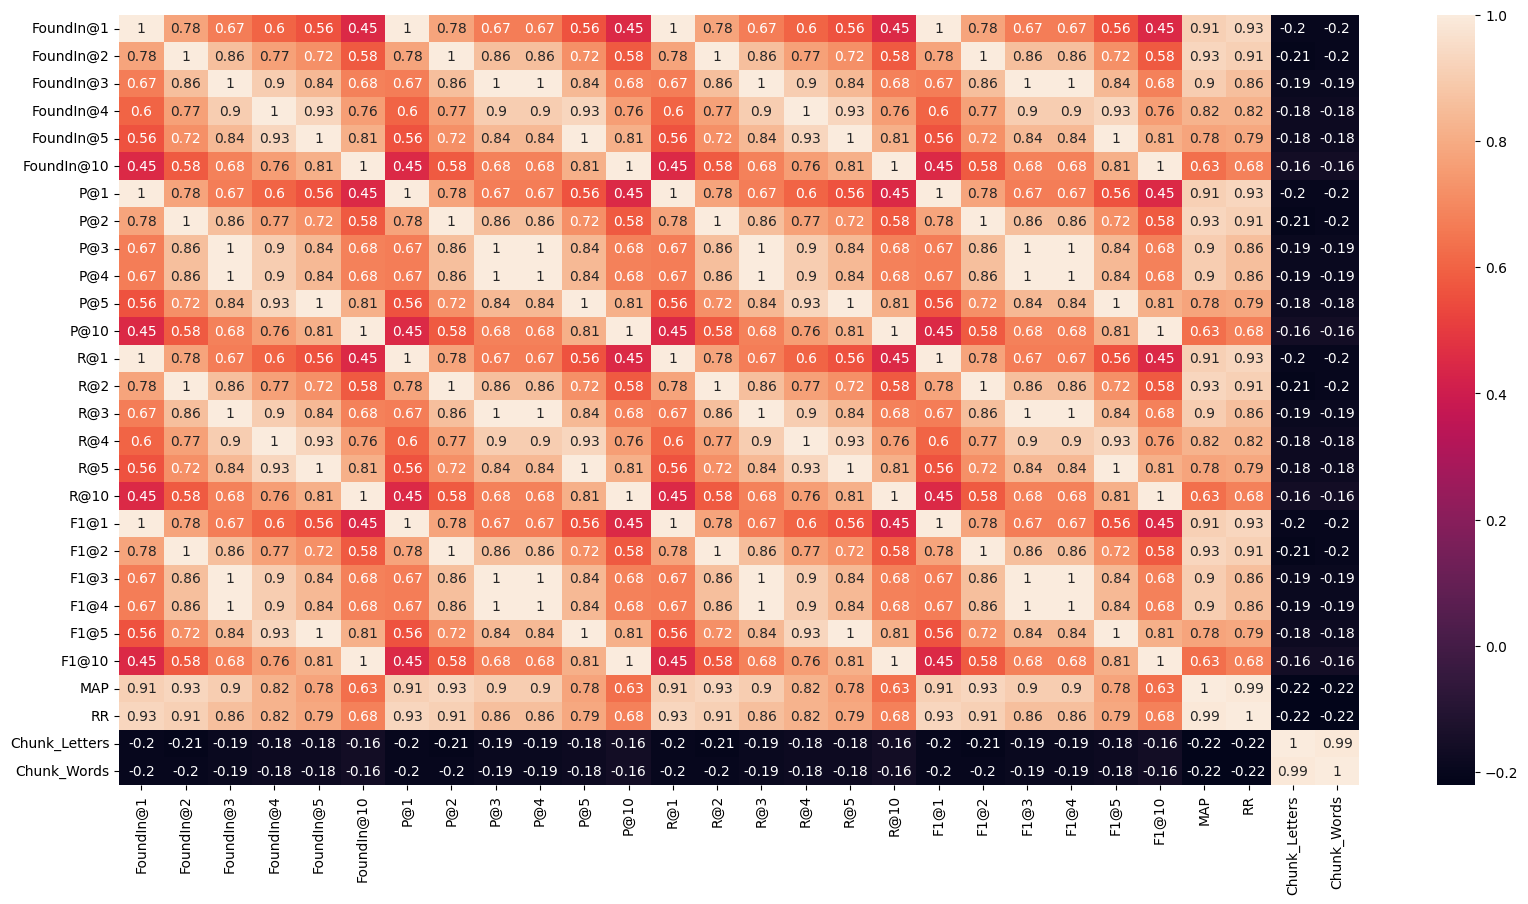

In [ ]:
df_corr = round(df_results[['FoundIn@1', 'FoundIn@2', 'FoundIn@3','FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1', 'P@2', 'P@3', 'P@4',
       'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5', 'R@10', 'F1@1',
       'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR',
       'Chunk_Letters', 'Chunk_Words']].corr(),2)

plt.figure(figsize=(20,10))
sns.heatmap(df_corr, annot=True)
plt.show()

In [ ]:
# df_results.columns

# DRS with minilm

In [ ]:
embmodelname, embmodelshort, embmodelname1 = select_model(1)

df_hbqa_chunk = pd.read_csv(datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv')

df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens',
       'ChunkVector'+embmodelname1]]

df_doc_predby = pd.read_csv(datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv")
df_doc_predby = df_doc_predby[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
       'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
       'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
       'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


df_results = df_doc_predby.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

df_results.sample(3)

all-MiniLM-L6-v2 	 minilm 	 _all-MiniLM-L6-v2


,Ques_Id,Chunk_Id,FoundIn@1,FoundIn@2,FoundIn@3,FoundIn@4,FoundIn@5,FoundIn@10,P@1,P@2,...,F1@4,F1@5,F1@10,MAP,RR,Section_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,ChunkVector_all-MiniLM-L6-v2
369,369,522,False,False,False,False,False,False,False,0.0,...,0.0,0.00,0.00,0.00,0.0,Book03_110,5023,905,1204,"[-0.04181194677948952, 0.10562654584646225, -0..."
143,143,453,False,False,False,False,False,False,False,0.0,...,0.0,0.00,0.00,0.00,0.0,Book03_054,4331,733,975,"[-0.040428970009088516, 0.02891123667359352, -..."
706,706,683,False,True,True,True,True,True,False,0.5,...,0.4,0.33,0.18,0.26,0.5,Book03_232,2730,475,632,"[-0.09633564949035645, 0.09397371858358383, 0...."


# DRS with Distilroberta

In [ ]:
embmodelname, embmodelshort, embmodelname1 = select_model(2)

df_hbqa_chunk = pd.read_csv(datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv')

df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens',
       'ChunkVector'+embmodelname1]]

df_doc_predby = pd.read_csv(datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv")
df_doc_predby = df_doc_predby[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
       'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
       'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
       'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


df_results = df_doc_predby.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

df_results.sample(3)

all-distilroberta-v1 	 distilroberta 	 _all-distilroberta-v1


,Ques_Id,Chunk_Id,FoundIn@1,FoundIn@2,FoundIn@3,FoundIn@4,FoundIn@5,FoundIn@10,P@1,P@2,...,F1@4,F1@5,F1@10,MAP,RR,Section_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,ChunkVector_all-distilroberta-v1
758,758,703,True,True,True,True,True,True,True,0.5,...,0.4,0.33,0.18,0.46,1.0,Book03_252,4603,760,1011,"[0.010167095810174942, -0.06162333860993385, 0..."
480,480,559,False,False,False,False,False,False,False,0.0,...,0.0,0.00,0.00,0.00,0.0,Book03_141,2929,499,664,"[-0.010963196866214275, -0.014257805421948433,..."
191,191,467,True,True,True,True,True,True,True,0.5,...,0.4,0.33,0.18,0.46,1.0,Book03_065,4851,846,1125,"[0.00501280976459384, -0.048728879541158676, -..."


# DRS for mpnet

In [ ]:
embmodelname, embmodelshort, embmodelname1 = select_model(3)

df_hbqa_chunk = pd.read_csv(datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv')

df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens',
       'ChunkVector'+embmodelname1]]

df_doc_predby = pd.read_csv(datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv")
df_doc_predby = df_doc_predby[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
       'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
       'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
       'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


df_results = df_doc_predby.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

df_results.sample(3)

multi-qa-mpnet-base-dot-v1 	 mpnet 	 _multi-qa-mpnet-base-dot-v1


,Ques_Id,Chunk_Id,FoundIn@1,FoundIn@2,FoundIn@3,FoundIn@4,FoundIn@5,FoundIn@10,P@1,P@2,...,F1@4,F1@5,F1@10,MAP,RR,Section_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,ChunkVector_multi-qa-mpnet-base-dot-v1
858,858,762,True,True,True,True,True,True,True,0.5,...,0.4,0.33,0.18,0.46,1.00,Book03_299,2972,541,720,"[0.2870217561721802, -0.05366259068250656, -0...."
126,126,440,False,False,True,True,True,True,False,0.0,...,0.4,0.33,0.18,0.16,0.33,Book03_043,5198,877,1166,"[-0.2267971634864807, -0.14895160496234894, -0..."
564,564,597,False,False,False,True,True,True,False,0.0,...,0.0,0.33,0.18,0.04,0.25,Book03_170,4219,716,952,"[-0.0009103909251280129, -0.1669967770576477, ..."


# DRS for Roberta

In [ ]:
embmodelname, embmodelshort, embmodelname1 = select_model(4)

df_hbqa_chunk = pd.read_csv(datapath + '07.1-HBQA_Chunk_Vector'+embmodelname1+'.csv')

df_hbqa_chunk = df_hbqa_chunk[['Section_Id', 'Chunk_Id', 'Chunk_Letters', 'Chunk_Words',
       'Chunk_Approx_Tokens',
       'ChunkVector'+embmodelname1]]

df_doc_predby = pd.read_csv(datapath + "08.2-Predict-DocumentId-for-Ques-Metrics" + embmodelname1 + ".csv")
df_doc_predby = df_doc_predby[['Ques_Id', 'Chunk_Id', 'FoundIn@1',
       'FoundIn@2', 'FoundIn@3', 'FoundIn@4', 'FoundIn@5', 'FoundIn@10', 'P@1',
       'P@2', 'P@3', 'P@4', 'P@5', 'P@10', 'R@1', 'R@2', 'R@3', 'R@4', 'R@5',
       'R@10', 'F1@1', 'F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']]


df_results = df_doc_predby.merge(df_hbqa_chunk, how='left', on='Chunk_Id')

df_results.sample(3)

all-roberta-large-v1 	 roberta 	 _all-roberta-large-v1


,Ques_Id,Chunk_Id,FoundIn@1,FoundIn@2,FoundIn@3,FoundIn@4,FoundIn@5,FoundIn@10,P@1,P@2,...,F1@4,F1@5,F1@10,MAP,RR,Section_Id,Chunk_Letters,Chunk_Words,Chunk_Approx_Tokens,ChunkVector_all-roberta-large-v1
920,920,790,False,False,True,True,True,True,False,0.0,...,0.4,0.33,0.18,0.16,0.33,Book04_011,2744,463,616,"[-0.006342510227113962, 0.05525217950344086, 0..."
970,970,815,True,True,True,True,True,True,True,0.5,...,0.4,0.33,0.18,0.46,1.00,Book04_033,5580,913,1214,"[0.0019247683230787516, 0.05238327011466026, 0..."
377,377,524,True,True,True,True,True,True,True,0.5,...,0.4,0.33,0.18,0.46,1.00,Book03_111,4834,858,1141,"[0.0027953924145549536, 0.0551530197262764, -0..."


In [ ]:
pd.DataFrame(summary_results)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 3))

sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@1", ax=ax[0,0])
sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@2", ax=ax[0,1])
sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@3", ax=ax[0,2])
sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@4", ax=ax[1,0])
sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@5", ax=ax[1,1])
sns.scatterplot(df_results, x="Chunk_Words",y="FoundIn@10", ax=ax[1,2])

# Adjust layout to prevent subplot overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
cols = ['Ques_Id', 'Chunk_Id','Section_Id','Chunk_Letters','Chunk_Words']
cols1 = ['FoundIn@1', 'FoundIn@2', 'FoundIn@3','FoundIn@4', 'FoundIn@5', 'FoundIn@10']
cols2 = ['P@1', 'P@2', 'P@3', 'P@4','P@5', 'P@10',]
cols3 = ['R@1', 'R@2', 'R@3', 'R@4', 'R@5', 'R@10',]
cols4 = ['F1@1','F1@2', 'F1@3', 'F1@4', 'F1@5', 'F1@10', 'MAP', 'RR']

df_results1 = df_results[  (",".join(cols)+","+",".join(cols1)).split(",")  ]
print(df_results1.shape)
df_results1.head(3)
df_results1.describe()#.loc[ df_results['Chunk_Words']<500,:].describe()

(1102, 11)


,Ques_Id,Chunk_Id,Chunk_Letters,Chunk_Words
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,550.500000,580.468240,4057.423775,698.495463
std,318.264303,154.255154,1098.882089,191.875692
min,0.000000,27.000000,739.000000,127.000000
25%,275.250000,477.000000,3314.000000,563.000000
50%,550.500000,566.000000,4207.000000,722.000000
75%,825.750000,700.000000,4946.500000,851.000000
max,1101.000000,989.000000,5995.000000,1000.000000


In [ ]:
df_results1 = df_results[  (",".join(cols)+","+",".join(cols2)).split(",")  ]
print(df_results1.shape)
df_results1.head(3)
df_results1.describe()

(1102, 11)


,Ques_Id,Chunk_Id,Chunk_Letters,Chunk_Words,P@2,P@3,P@4,P@5,P@10
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,550.500000,580.468240,4057.423775,698.495463,0.235481,0.176679,0.133848,0.121779,0.070962
std,318.264303,154.255154,1098.882089,191.875692,0.249691,0.164661,0.124743,0.097644,0.045414
min,0.000000,27.000000,739.000000,127.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,275.250000,477.000000,3314.000000,563.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550.500000,566.000000,4207.000000,722.000000,0.000000,0.330000,0.250000,0.200000,0.100000
75%,825.750000,700.000000,4946.500000,851.000000,0.500000,0.330000,0.250000,0.200000,0.100000
max,1101.000000,989.000000,5995.000000,1000.000000,0.500000,0.330000,0.250000,0.200000,0.100000


Relationship between number of words in chunk and find correct document is negative. It means more the words in chunk ease of finding document related document decreases

# Question & Answer Similarity

In [ ]:
df_qa_cos = pd.read_csv(datapath + '31.6-All-Model-QA-Cosine.csv')
df_qa_cos

,Model_Name,Cosine
0,multi-qa-distilbert-cos-v1,0.779
1,all-MiniLM-L6-v2,0.780
2,all-distilroberta-v1,0.710
3,multi-qa-mpnet-base-dot-v1,0.766
4,all-roberta-large-v1,0.731
